## BRCA test prediction for Lynparza patients
* Positive set contains 20 day multihot encoded event sequences of patients who have undergone BRCA test and given Lynparza
* Negative set contains 20 day multihot encoded event sequences of patients with no BRCA or Lynparza prescribed in their journey

`The events sequences which contain BRCA in then have been removed from the positive set`

##### Only claims table have been used to build this model

In [49]:
!pip install pyathena, tqdm &> /dev/null

In [52]:
import pyathena, tqdm
import boto3
import numpy as np
import pandas as pd
from time import sleep
import pickle
from tqdm import tqdm

In [60]:
import boto3
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
import functools
from datetime import timedelta, datetime
np.random.seed(42)
%matplotlib inline

In [35]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from pyathena import connect
import pandas as pd
conn = connect(s3_staging_dir='s3://aws-athena-query-results-452536012049-us-east-1/zep.dev',
               region_name='us-east-1')

df = pd.read_sql("select distinct(claim_type_sub_class) from o2_prod_app_commons.patient_tumor_onc_universal_claims", conn)


In [17]:
df[df['claim_type_sub_class']=='BRCA_TEST']

,claim_type_sub_class
69,BRCA_TEST


In [19]:
import pickle
event_dict1={}
for i,event in enumerate(df['claim_type_sub_class'].values):
    event_dict1[event]=i
with open('event_id_dict_from_db.pkl','wb') as write_file:
    pickle.dump(event_dict1,write_file)

In [20]:
with open('event_id_dict_from_db.pkl','rb') as read_file:
    event_dict=pickle.load(read_file)
len(list(event_dict.keys()))

317

In [21]:
event_dict=list(event_dict.keys())
event_dict.remove('BRCA_TEST')
event_id_dict={}
for i,event in enumerate(event_dict):
    event_id_dict[event]=i

In [24]:
positive_patients_journey=pd.read_csv("s3://azai-proto-spark/rahul/onco/patient_journey_brca_lynparza_positive_8k.csv")
negative_patients_journey=pd.read_csv("s3://azai-proto-spark/rahul/onco/patient_journey_no_brca_50k.csv")

In [25]:
negative_patients_journey.shape, positive_patients_journey.shape

((10877545, 5), (5476384, 5))

In [26]:
positive_patients_journey.patient_id.nunique(), negative_patients_journey.patient_id.nunique()

(8459, 50000)

In [27]:
positive_patients_journey.claim_type_sub_class = positive_patients_journey.claim_type_sub_class.apply(str.strip)
negative_patients_journey.claim_type_sub_class = negative_patients_journey.claim_type_sub_class.apply(str.strip)

In [28]:
positive_patients_journey.claim_date = pd.to_datetime(positive_patients_journey.claim_date)
negative_patients_journey.claim_date = pd.to_datetime(negative_patients_journey.claim_date)

In [29]:
positive_patients_journey.patient_id.unique()

array([1000370209, 1001399874, 1001564645, ...,  998880960,  999289148,
         99966987])

In [30]:
negative_patients_journey.patient_id.unique()

array([1000067051, 1000073389, 1000134822, ...,  999887654,  999889189,
        999924519])

In [31]:
positive_patient = positive_patients_journey[positive_patients_journey.patient_id == 1001399874]

In [32]:
negative_patient = negative_patients_journey[negative_patients_journey.patient_id == 999924519]

In [33]:
import matplotlib.patches as mpatch
import matplotlib.cm as cm
from matplotlib import dates as mdates

def visualize_journey(data_frame,category_col, event_col, tumor_col, date_col, title = ''):
    tumor_types = ['BLADDER', 'NSCLC', 'MCL', 'OVARIAN', 'BREAST','HCL']
    tumor_colors = ['b', 'c', 'y', 'm', 'r', 'g']
    bg_category = ['PROCEDURE', 'DRUG_TREATMENT', 'DIAGNOSIS', 'TEST', 'BIOPSY', 'ER', 'RADIATION',
                 'SURGERY', 'SCT', 'VISIT']
    bg_color = ['xkcd:ecru', 'xkcd:pale lavender','xkcd:celadon', 'xkcd:powder blue', 'xkcd:mauve',
                 'xkcd:pale blue', 'xkcd:light grey', 'xkcd:light beige', 'xkcd:light yellow', 'xkcd:very light pink']

    data_frame[date_col] = pd.to_datetime(data_frame[date_col])
    claim_class = data_frame[category_col].unique().tolist()
    h_ratios =[]
    for c in claim_class:
        h_ratios.append(data_frame[data_frame[category_col] == c][event_col].unique().shape[0])
    h_ratios = [ h_rat*2 for h_rat in h_ratios]

    fig, axes = plt.subplots(len(claim_class), 1, sharex=True, figsize=(20,10), gridspec_kw = {'height_ratios':h_ratios})
    legend_handles, legend_labels = [], []
    for i, ax in enumerate(axes.ravel()):
        data_part = data_frame[data_frame[category_col]==claim_class[i]]
        for tumor_type in data_part[tumor_col].unique():
            mask = data_part[tumor_col] == tumor_type
            x = list(data_part[mask][date_col])
            y = list(data_part[mask][event_col])
            c = tumor_colors[tumor_types.index(tumor_type)]
            ax.scatter(x, y, c=c, cmap=cm.brg, marker="D", label =tumor_type)
        ax.set_facecolor(bg_color[bg_category.index(claim_class[i])])
        ax.set_ylabel(claim_class[i] ,rotation =  'horizontal',labelpad =60)
        ax.grid(True)
        h, l = ax.get_legend_handles_labels()
        legend_handles.append(h)
        legend_labels.append(l)
    plt.subplots_adjust(hspace=0.08)
    plt.suptitle(title, fontsize=25)
    patches = [ plt.plot([],[], marker="D", ms=8, ls="", mec=None, color=tumor_colors[i],
           label="{:s}".format(tumor_types[i]) )[0]  for i in range(len(tumor_types)) ]

    plt.legend(handles = patches,
              scatterpoints=1,
              bbox_to_anchor=(0.75, -0.8),
              ncol=6,
              fontsize=10)

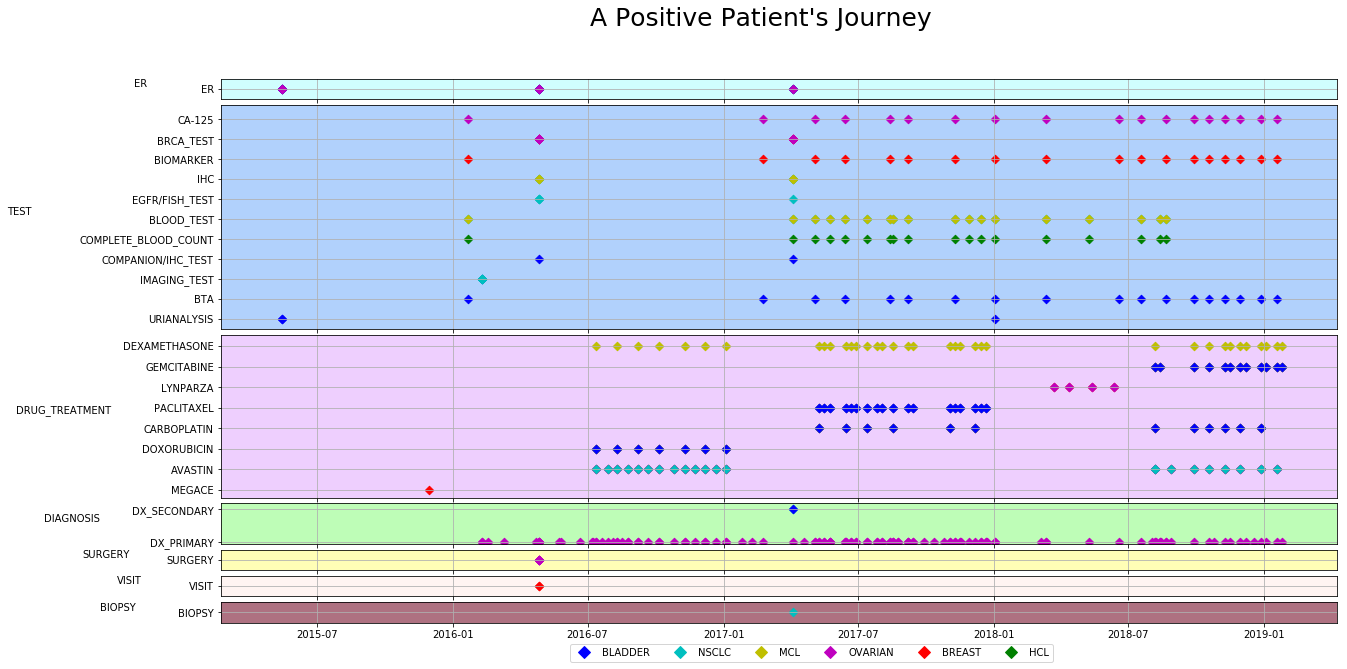

In [36]:
visualize_journey(positive_patient,'claim_type_category' ,'claim_type_sub_class','tumor','claim_date',
                 title = "A Positive Patient's Journey")

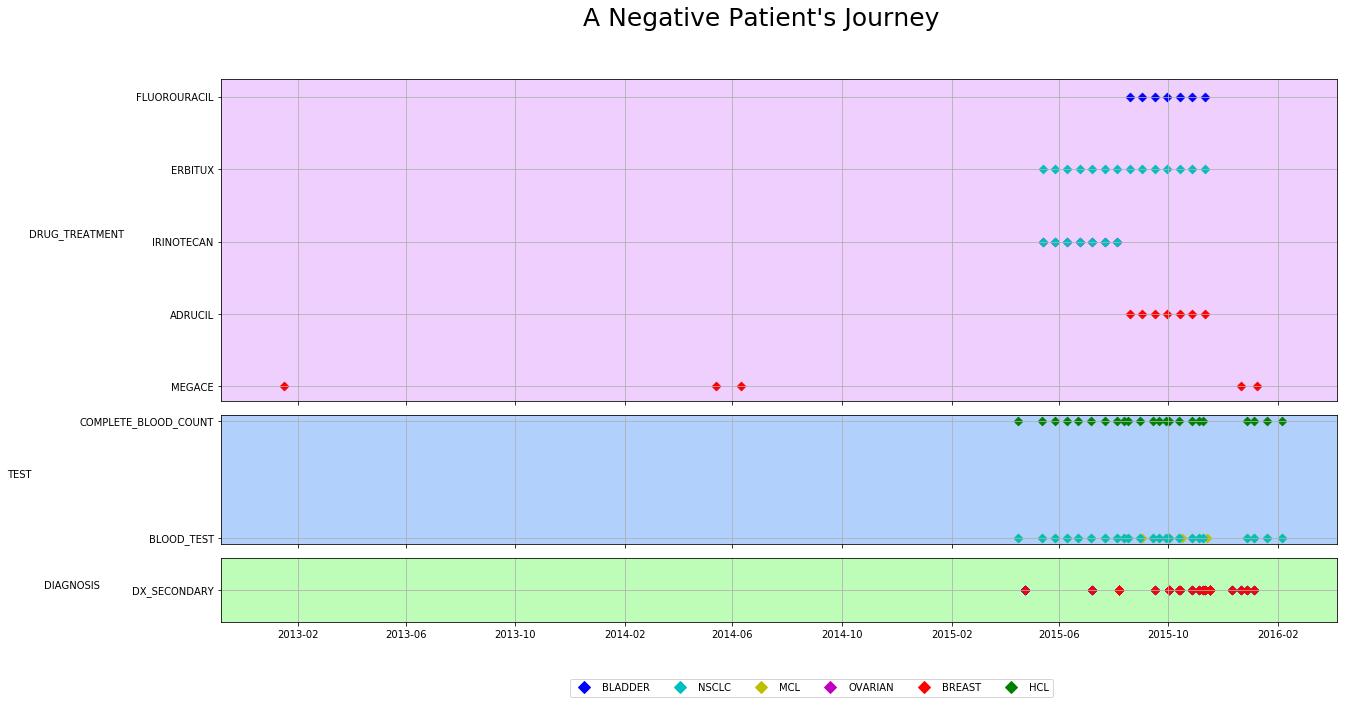

In [37]:
visualize_journey(negative_patient,'claim_type_category' ,'claim_type_sub_class','tumor','claim_date',
                 title = "A Negative Patient's Journey")

In [38]:
def gen_target_dates(df,event='BRCA_TEST'):
    target_dates={}
    groupby_df=df.groupby("patient_id")
    for pid,frame in groupby_df:
        sorted_frame=frame.sort_values(by='claim_date',axis=0)
        target_event_frame = sorted_frame[sorted_frame['claim_type_sub_class']==event]
        target_date = target_event_frame['claim_date']
        target_dates[pid]=target_date.unique()
    return target_dates

def mhe(data_seq, len_events=316, sequences=20):
    x=np.zeros(len_events)
    positive_events=[]
    for seq in data_seq:
        for data_point in seq:
            x[event_id_dict[data_point]]=1
        positive_events.append(x)
    return positive_events   

In [42]:
def get_positive_sequences(journey_data, sequences=20,event='BRCA_TEST'):
    patient_events=[]
    data_groupby_pid=journey_data.groupby("patient_id")
    for pid,frame in tqdm(data_groupby_pid, leave=False):
        sorted_frame=frame.sort_values(by="claim_date")
        target_dates = gen_target_dates(sorted_frame)
        occurance_dates = target_dates[pid]
        for target_time in occurance_dates:
            patient_events_day_level=[]
            event_df= sorted_frame[(sorted_frame['claim_date']< target_time)]
            if(event in event_df.claim_type_sub_class.unique().tolist()):
                pass
            else:
                grp_by = event_df.groupby('claim_date')
                group_list = list(grp_by)
                if(len(group_list) < sequences):
                    continue 
                else:
                    for day_grp in group_list[-sequences::]:
                            patient_events_day_level.append(day_grp[1]['claim_type_sub_class'].unique())                       
                    patient_event_mhe=mhe(patient_events_day_level)
                patient_events.append(patient_event_mhe)
    return np.array(patient_events) 

In [43]:
def get_sequences(pid_seq,sequences=20):
    final_seq=[]
    len_seq=len(pid_seq)
    for i in range(len_seq//sequences):
        seq=pid_seq[len_seq-(i+1)*sequences: len_seq-(i)*sequences]
        final_seq.append(np.array(seq))
    return final_seq

def get_negative_sequences(journey_data,sequences=20):
    patient_events=[]
    data_groupby_pid=journey_data.groupby("patient_id")
    for pid,frame in tqdm(data_groupby_pid, leave=False):
        sorted_frame=frame.sort_values(by="claim_date")
        grp_by = sorted_frame.groupby('claim_date')
        group_list = list(grp_by)
        if(len(group_list) < sequences):
                continue
        else:
            final_seq=get_sequences(group_list)
            for seq in final_seq:
                patient_events_day_level=[]
                for grp_date in seq:
                    patient_events_day_level.append(grp_date[1]['claim_type_sub_class'].unique())
                patient_event_mhe=mhe(patient_events_day_level)
                patient_events.append(patient_event_mhe)
    return np.array(patient_events)

In [44]:
positive_pid=positive_patients_journey.patient_id.unique()
negative_pid=negative_patients_journey.patient_id.unique()

In [45]:
positive_pid_len = positive_pid.shape[0]
train_positive_pid=positive_pid[0: int(0.6*positive_pid_len)]
cv_positive_pid=positive_pid[int(0.6*positive_pid_len) : int(0.8*positive_pid_len)]
test_positive_pid=positive_pid[int(0.8*positive_pid_len) :]

In [46]:
negative_pid_len = negative_pid.shape[0]
train_negative_pid=negative_pid[0:int(0.6*negative_pid_len)]
cv_negative_pid=negative_pid[int(0.6*negative_pid_len) : int(0.8*negative_pid_len)]
test_negative_pid=negative_pid[int(0.8*negative_pid_len):]

In [47]:
train_positive_data=positive_patients_journey[positive_patients_journey.patient_id.isin(train_positive_pid)]
cv_positive_data=positive_patients_journey[positive_patients_journey.patient_id.isin(cv_positive_pid)]
test_positive_data=positive_patients_journey[positive_patients_journey.patient_id.isin(test_positive_pid)]

train_negative_data=negative_patients_journey[negative_patients_journey.patient_id.isin(train_negative_pid)]
cv_negative_data=negative_patients_journey[negative_patients_journey.patient_id.isin(cv_negative_pid)]
test_negative_data=negative_patients_journey[negative_patients_journey.patient_id.isin(test_negative_pid)]

In [53]:
train_brca_data=get_positive_sequences(train_positive_data)
cv_brca_data=get_positive_sequences(cv_positive_data)
test_brca_data=get_positive_sequences(test_positive_data)

In [54]:
print(train_brca_data.shape,cv_brca_data.shape,test_brca_data.shape)

(1548, 20, 316) (497, 20, 316) (522, 20, 316)


In [55]:
train_no_brca_data=get_negative_sequences(train_negative_data)
cv_no_brca_data=get_negative_sequences(cv_negative_data)
test_no_brca_data=get_negative_sequences(test_negative_data)

In [56]:
print(train_no_brca_data.shape,cv_no_brca_data.shape,test_no_brca_data.shape)

(62649, 20, 316) (20066, 20, 316) (18215, 20, 316)


In [57]:
x_train = np.concatenate([train_brca_data, train_no_brca_data])
y_train = np.array([1]*train_brca_data.shape[0] + [0]*train_no_brca_data.shape[0])

x_cv = np.concatenate([cv_brca_data, cv_no_brca_data])
y_cv = np.array([1]*cv_brca_data.shape[0] + [0]*cv_no_brca_data.shape[0])

x_test = np.concatenate([test_brca_data, test_no_brca_data])
y_test = np.array([1]*test_brca_data.shape[0] + [0]*test_no_brca_data.shape[0])

In [58]:
print(x_train.shape,x_cv.shape,x_test.shape)
print(y_train.shape,y_cv.shape,y_test.shape)

(64197, 20, 316) (20563, 20, 316) (18737, 20, 316)
(64197,) (20563,) (18737,)


In [61]:
x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=0, random_state=52)
x_cv, _, y_cv, _ = train_test_split(x_cv, y_cv, test_size=0, random_state=52)

In [62]:
if tf.test.is_gpu_available():
    rnn = tf.keras.layers.CuDNNGRU
else:
    rnn = functools.partial(
        tf.keras.layers.GRU, recurrent_activation='sigmoid')
    
def build_model(units,vocab_size,time_steps,drop_out=0.1):
    input_sequences = tf.keras.layers.Input(shape=(time_steps, vocab_size),name='main_input')
    reduced_dim=tf.keras.layers.Dense(16)(input_sequences)
    gru_out =rnn(units,name="gru")(reduced_dim)
    gru_out=tf.keras.layers.Dropout(drop_out)(gru_out)
    gru_out=tf.keras.layers.BatchNormalization()(gru_out)
    ctg_out=tf.keras.layers.Dense(1,activation="sigmoid",name='ctg_out')(gru_out)
    model = tf.keras.Model(inputs=input_sequences, outputs=ctg_out)
    return model

In [63]:
model=build_model(32,316,20)

In [64]:
model.compile("adam",loss='binary_crossentropy',metrics=['accuracy'])

In [65]:
model.fit(x=x_train,y=y_train,batch_size=64,validation_data=(x_cv,y_cv),epochs=10)

Train on 64197 samples, validate on 20563 samples
Epoch 1/10
64197/64197 [==============================] - 12s 185us/step - loss: 0.1467 - acc: 0.9604 - val_loss: 0.0555 - val_acc: 0.9856
Epoch 2/10
64197/64197 [==============================] - 11s 174us/step - loss: 0.0542 - acc: 0.9846 - val_loss: 0.0505 - val_acc: 0.9840
Epoch 3/10
64197/64197 [==============================] - 11s 174us/step - loss: 0.0514 - acc: 0.9850 - val_loss: 0.0476 - val_acc: 0.9852
Epoch 4/10
64197/64197 [==============================] - 11s 175us/step - loss: 0.0505 - acc: 0.9852 - val_loss: 0.0467 - val_acc: 0.9855
Epoch 5/10
64197/64197 [==============================] - 11s 175us/step - loss: 0.0492 - acc: 0.9855 - val_loss: 0.0473 - val_acc: 0.9856
Epoch 6/10
64197/64197 [==============================] - 11s 174us/step - loss: 0.0488 - acc: 0.9856 - val_loss: 0.0474 - val_acc: 0.9860
Epoch 7/10
64197/64197 [==============================] - 11s 174us/step - loss: 0.0479 - acc: 0.9859 - val_loss: 0.

In [66]:
import numpy as np
from sklearn import metrics
y_pred=model.predict(x_test)
y_predicted=y_pred.flatten()

In [67]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted)
auc_score = metrics.auc(fpr, tpr)
print("AUC Score:- {}" .format(auc_score))

AUC Score:- 0.9804116013180161


Text(33,0.5,'Original class')

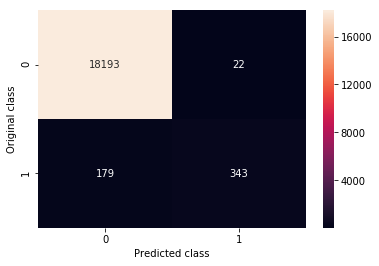

In [70]:
y_predicted_binaries=y_predicted.copy()
y_predicted_binaries[y_predicted_binaries>=0.5]=1
y_predicted_binaries[y_predicted_binaries<0.5]=0
sns.heatmap(metrics.confusion_matrix(y_test,y_predicted_binaries),annot=True, fmt="0.0f")
plt.xlabel("Predicted class")
plt.ylabel("Original class")

In [72]:
model.save_weights('model_weights/brca_model_prediction_2.h5')

In [73]:
X_train_counts = x_train.sum(axis=1)
X_cv_counts = x_cv.sum(axis=1)
X_test_counts = x_test.sum(axis=1)

In [74]:
print(X_train_counts.shape)

(64197, 316)


In [75]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(X_train_counts, y_train)
y_binary=clf.predict(X_test_counts)
y_pbts=clf.predict_proba(X_test_counts)

In [76]:
y_pbts=y_pbts[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pbts)
print("AUC-score {}".format(metrics.auc(fpr, tpr)))

AUC-score 0.9779125031683078


In [77]:
precision, recall, threshold = metrics.precision_recall_curve(y_test,y_pbts)

Text(0.5,1,'Logistic-Regression-model')

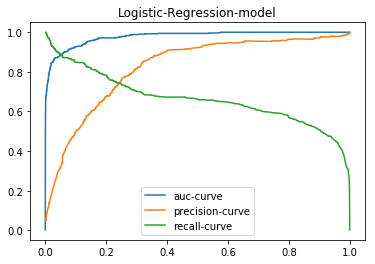

In [78]:
plt.plot(fpr, tpr)
plt.plot(threshold,precision[:-1])
plt.plot(threshold,recall[:-1])
plt.legend(("auc-curve","precision-curve","recall-curve"))
plt.title("Logistic-Regression-model")

In [79]:
weights=clf.coef_;weights=weights[0]
df=pd.DataFrame()
df["weights"]=weights
df["range"]=list(range(0,316))
id_to_event = {v: k for k, v in event_id_dict.items()}
df["event"]=df["range"].apply(lambda x:id_to_event[x])
df.set_index("event",inplace=True)

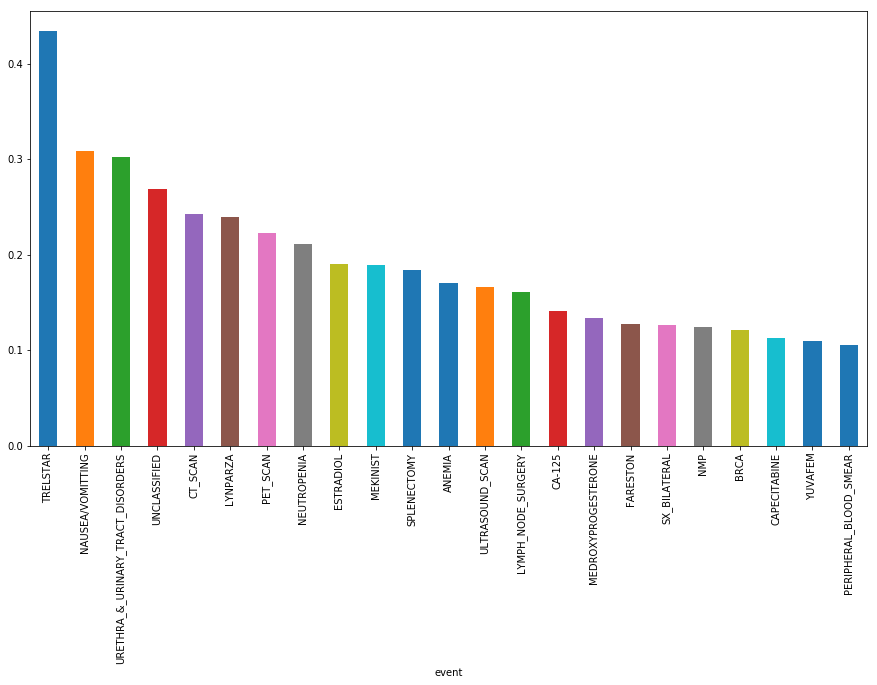

In [80]:
df[df["weights"]>0.1]["weights"].sort_values(ascending=False).plot(kind="bar",figsize=(15,8))

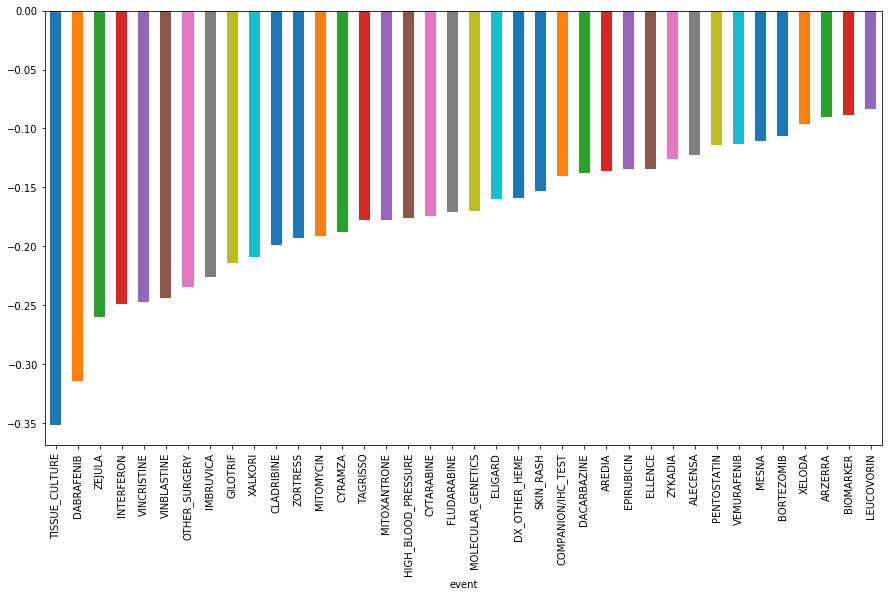

In [81]:
df[df["weights"]<-0.08]['weights'].sort_values().plot(kind="bar",figsize=(15,8))